In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_e = 'red'
color_i = 'blue'

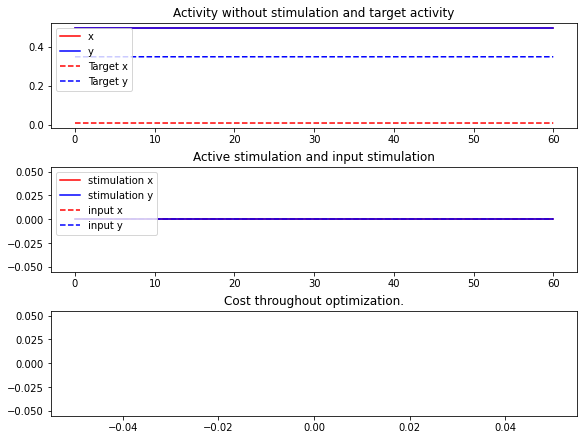

In [2]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = wc.params["dt"]
duration = 60.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["duration"] = duration
x_init = 0.
y_init = 0.
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])
# bistable region, system goes into down state
down_stimulus = zero_input.copy()
down_stimulus[0,:500] = -2.
wc.params["exc_ext"] = down_stimulus + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()
down_init_e = wc.exc[0,-1]
down_init_i = wc.inh[0,-1]

wc.params["exc_init"] = np.array([[down_init_e]])
wc.params["inh_init"] = np.array([[down_init_i]])
wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()

target = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

up_stimulus = zero_input.copy()
up_stimulus[0,:500] = 2.
wc.params["exc_ext"] = up_stimulus + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.run()
up_init_e = wc.exc[0,-1]
up_init_i = wc.inh[0,-1]

wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.params["exc_init"] = np.array([[up_init_e]])
wc.params["inh_init"] = np.array([[up_init_i]])
wc.run()


state = np.concatenate( (np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis],
            np.stack( (wc.exc, wc.inh), axis=1)), axis=2) 
plot_oc_singlenode(duration, dt, state, target, np.zeros((target.shape)), np.zeros((target.shape)))

Compute control for a deterministic system
Cost in iteration 0: 23.81091500788357
23.81091500788357 16979619104.201067 10.0 -0.0
23.81091500788357 4244904776.0567293 5.0 -0.0
23.81091500788357 1061226194.0196952 2.5 -0.0
23.81091500788357 265306548.5092984 1.25 -0.0
23.81091500788357 66326637.13043757 0.625 -0.0
23.81091500788357 16581659.284435526 0.3125 -0.0
23.81091500788357 4145414.8218891383 0.15625 -0.0
23.81091500788357 1036353.7056954629 0.078125 -0.0
23.81091500788357 259088.42646657766 0.0390625 -0.0
23.81091500788357 64772.10662246804 0.01953125 -0.0
23.81091500788357 16193.02665624181 0.009765625 -0.0
23.81091500788357 4048.256664121228 0.0048828125 -0.0
23.81091500788357 1012.0641660367594 0.00244140625 -0.0
23.81091500788357 253.01604151001223 0.001220703125 -0.0
23.81091500788357 63.25401037761846 0.0006103515625 -0.0
Cost in iteration 1: 15.813502594420504
15.813502594420504 23.810915009023947 10.0 0.34562648830485526
15.813502594420504 27.764170747347837 5.0 0.34562648

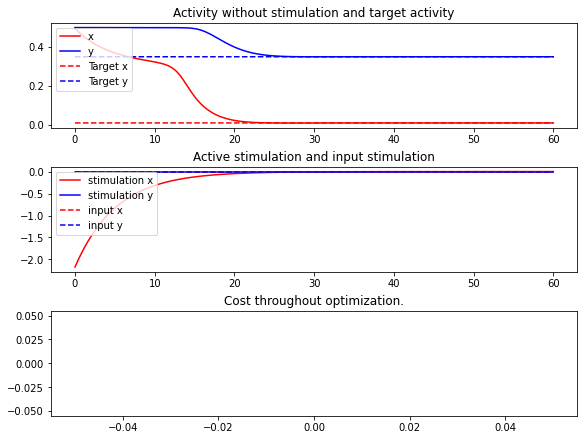

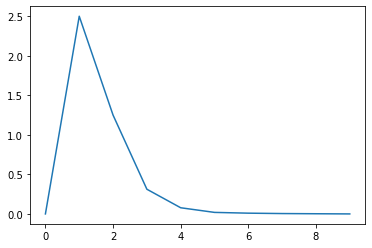

In [8]:
wc.params["exc_ext"] = zero_input + 4.
wc.params["inh_ext"] = zero_input + 4.
wc.params["exc_init"] = np.array([[up_init_e]])
wc.params["inh_init"] = np.array([[up_init_i]])
w2 = 0.1
wp = 1.
precision_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
precision_mat[0,0] = 1.
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100)) )
wc_controlled_noisefree = oc_wc.OcWc(wc, target, w_p=wp, w_2=w2, print_array=printarray,
                    control_matrix=control_mat,
                    precision_matrix = precision_mat,
                    precision_cost_interval=(400,None))

wc_controlled_noisefree.step = 10.

control0 = np.zeros((target.shape))
#control0[0,0,380:400] = -2.
wc_controlled_noisefree.control = control0.copy()
wc_controlled_noisefree.update_input()
wc_controlled_noisefree.optimize(10)

state = wc_controlled_noisefree.get_xs()
control_noisefree = wc_controlled_noisefree.control

plot_oc_singlenode(duration, dt, state, target, control_noisefree, control0)

plt.plot(wc_controlled_noisefree.step_sizes_history)
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 19.27609107475838
19.27609107475838 46.117336340692404 10.0 0.2736003345511815
19.27609107475838 24.763980751899613 5.0 0.2736003345511815
19.27609107475838 28.716255001379558 2.5 0.2736003345511815
19.27609107475838 34.31156538166189 1.25 0.2736003345511815
19.27609107475838 37.96353029933036 0.625 0.2736003345511815
19.27609107475838 39.91498884970122 0.3125 0.2736003345511815
19.27609107475838 40.73367448195309 0.15625 0.2736003345511815
19.27609107475838 40.710566199329975 0.078125 0.2736003345511815
19.27609107475838 39.099592664040756 0.0390625 0.2736003345511815
19.27609107475838 19.40375145478046 0.01953125 0.2736003345511815
19.27609107475838 19.31016881688113 0.009765625 0.2736003345511815
19.27609107475838 19.28819544382479 0.0048828125 0.2736003345511815
19.27609107475838 19.281097273740492 0.00244140625 0.2736003345511815
19.27609107475838 19.278351711776963 0.001220703125 0.2736003345511815
19.27609107475838 

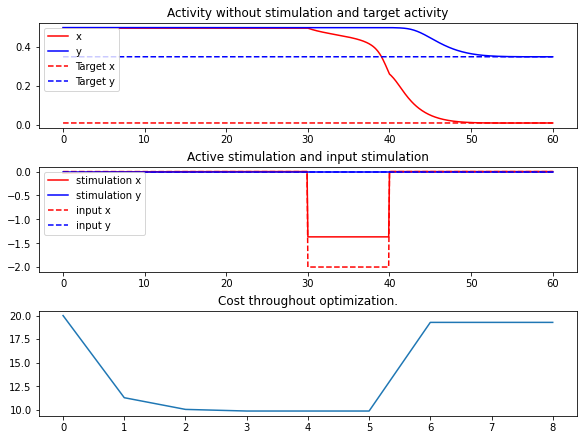

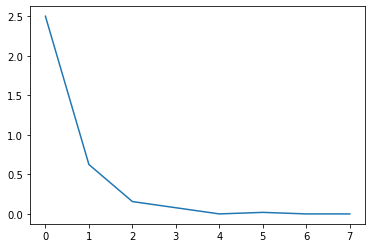

In [6]:
for w_2 in [0.2]:
    wc_controlled_noisefree.w_2 = w_2
    wc_controlled_noisefree.optimize(10)

    state = wc_controlled_noisefree.get_xs()
    control_noisefree = wc_controlled_noisefree.control

    plot_oc_singlenode(duration, dt, state, target, control_noisefree, control0, cost_array=wc_controlled_noisefree.cost_history)

plt.plot(wc_controlled_noisefree.step_sizes_history)
plt.show()